### Importo as bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dt
import matplotlib.pyplot as plt
import random
import math

### Importo os dados dos setores

In [2]:
# Importo a plan com os dados dos setores e ações
ibrx = pd.read_csv('ibrx2020.csv')

# Transformo em uma lista
stocks = list(ibrx['Ativo'])

### Puxo os dados do yahoo

In [3]:
# Defino qual será a data de início dos dataframes de preços
start_date = '2020-01-01'

# Crio um dicionário que irá conter a série de preços de cada ação
prices = {}

# Pego apenas a coluna Adjusted Close porque é o que me interessa
for s in range(0, len(stocks)):
    prices.update({stocks[s]:dt.DataReader(stocks[s], start=start_date, data_source='yahoo')['Adj Close']})

Wall time: 1min 47s


In [4]:
# Pego os dados do ibovespa
ibov = dt.DataReader('^BVSP', start=start_date, data_source='yahoo')['Adj Close']    

In [5]:
# Crio uma lista de preços que irá conter um pd.Series de preços para cada ação 
prices_list = []
for stock in prices.keys():
    prices_list.append(prices[stock])

In [6]:
# Agrupo os preços em apenas um dataframe
prices_df = pd.concat(prices_list, axis=1)
prices_df.columns = stocks

### Tratando a base de dados

In [7]:
# Crio uma função que preenche dados vazios
def fill_values(df):
    for i in df.columns.values:
        init = df[i].first_valid_index()
        end = df[i].last_valid_index()
        df[i].loc[init:end]=df[i].loc[init:end].fillna(method='ffill')

In [8]:
# Preencho os valores descontinuos de precos
fill_values(prices_df) # Há apenas um problema com TIMS3.SA, não há dados disponíveis no api yahoo
prices_df.drop('TIMS3.SA', axis=1, inplace=True)

### Calculando os retornos

In [9]:
# Calculo os retornos diarios de cada acao e do ibovespa
daily_returns = prices_df.pct_change()
ibov_returns = ibov.pct_change()

### Portfolios randomicos

In [10]:
%%time
# Faco um dicionario com os retornos diarios de cada portfolio randomico

random_returns = {}
portfolio_compo = {}
number = 10
n_test = 100000
for i in range(0, n_test):
    random_tickers = list(prices_df.columns[random.sample(range(len(stocks)-1), number)])
    returns = daily_returns[random_tickers].sum(axis=1)/number
    vol = returns.std()*(252**0.5)
    sharpe = (returns.mean()/returns.std())*(252**0.5)
    random_returns.update({i:[returns, random_tickers, vol, sharpe]})

Wall time: 3min 45s


### Retornos

In [11]:
# Crio uma lista de retornos que irá conter um pd.Series de retornos para cada portfolio
return_list = []
for i in range(0, n_test):
    return_list.append(random_returns[i][0])

In [12]:
# Agrupo os retornos em apenas um dataframe
rand_returns_df = pd.concat(return_list, axis=1)
rand_returns_df.columns = list(range(0, n_test)) 

#Calculo a performance
rand_performance = rand_returns_df.add(1).cumprod()

#Retornos do ibrx
ibrx_returns = daily_returns.sum(axis=1)/daily_returns.count(axis=1)

#Performance do ibrx
ibrx_perf = ibrx_returns.add(1).cumprod()

# IBRX

### Analise

In [13]:
# Vejo quais foram melhor e pior que o ibov
winners = list(rand_performance.tail(1)[rand_performance.tail(1)>ibrx_perf.tail(1)[0]].dropna(axis=1).columns)
loosers = list(rand_performance.tail(1)[rand_performance.tail(1)<ibrx_perf.tail(1)[0]].dropna(axis=1).columns)

print('Performance: \nGanhadores: {:.2%} \nPerdedores: {:.2%} \n'.format(len(winners)/n_test, len(loosers)/n_test))

Performance: 
Ganhadores: 47.35% 
Perdedores: 52.65% 



In [14]:
# Media da performance dos portfolios
rand_performance.tail(1).mean(axis=1)-1

Date
2020-10-26   -0.093702
dtype: float64

In [15]:
# Media da performance do iBRX
ibrx_perf.tail(1)-1

Date
2020-10-26   -0.091346
dtype: float64

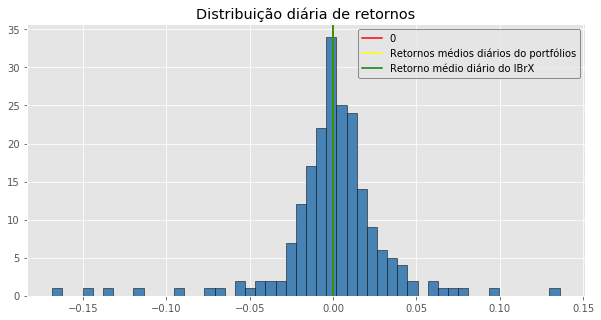

In [16]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.hist(rand_returns_df.mean(axis=1), color= 'steelblue',bins=50, edgecolor='black')
ax.axvline(x=0, color='red', label='0')
ax.axvline(x=rand_returns_df.mean().mean(), color='yellow', label='Retornos médios diários do portfólios')
ax.axvline(x=(daily_returns.sum(axis=1)/daily_returns.count(axis=1)).mean(), color='green', label='Retorno médio diário do IBrX')
ax.set_title('Distribuição diária de retornos')
ax.legend(loc='best', edgecolor='black')
#plt.savefig('distribution.png')
plt.show()

### Sharpe

In [17]:
# Crio uma lista de dos sharpes
sharpe_dict = {}
for i in range(0, n_test):
    sharpe_dict.update({i:random_returns[i][3]})
    
# Sharpe ibov
ibov_sharpe = ibov_returns.mean()/ibov_returns.std()*(252**0.5)

#Sharpe IBRX
ibrx_sharpe = ibrx_returns.mean()/ibrx_returns.std()*(252**0.5)

In [18]:
s_winners = list(pd.Series(sharpe_dict)[pd.Series(sharpe_dict)>ibrx_sharpe].index)
s_loosers = list(pd.Series(sharpe_dict)[pd.Series(sharpe_dict)<ibrx_sharpe].index)

print('Sharpe: \nGanhadores: {:.2%} \nPerdedores: {:.2%} \n'.format(len(s_winners)/n_test, len(s_loosers)/n_test))

Sharpe: 
Ganhadores: 49.87% 
Perdedores: 50.13% 



# Ibovespa

In [19]:
# Performance acumulada do ibov
ibov_last = (ibov/ibov.iloc[0]).tail(1)[0]

In [20]:
# Vejo quais foram melhor e pior que o ibov
winners = list(rand_performance.tail(1)[rand_performance.tail(1)>ibov_last].dropna(axis=1).columns)
loosers = list(rand_performance.tail(1)[rand_performance.tail(1)<ibov_last].dropna(axis=1).columns)

print('Performance: \nGanhadores: {:.2%} \nPerdedores: {:.2%} \n'.format(len(winners)/n_test, len(loosers)/n_test))

Performance: 
Ganhadores: 69.25% 
Perdedores: 30.75% 



In [21]:
s_winners = list(pd.Series(sharpe_dict)[pd.Series(sharpe_dict)>ibov_sharpe].index)
s_loosers = list(pd.Series(sharpe_dict)[pd.Series(sharpe_dict)<ibov_sharpe].index)

print('Sharpe: \nGanhadores: {:.2%} \nPerdedores: {:.2%} \n'.format(len(s_winners)/n_test, len(s_loosers)/n_test))

Sharpe: 
Ganhadores: 78.65% 
Perdedores: 21.35% 



In [22]:
# Performance do ibovespa
ibov_last-1

-0.1480610177907281

## Gráficos

c:\users\felipe\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


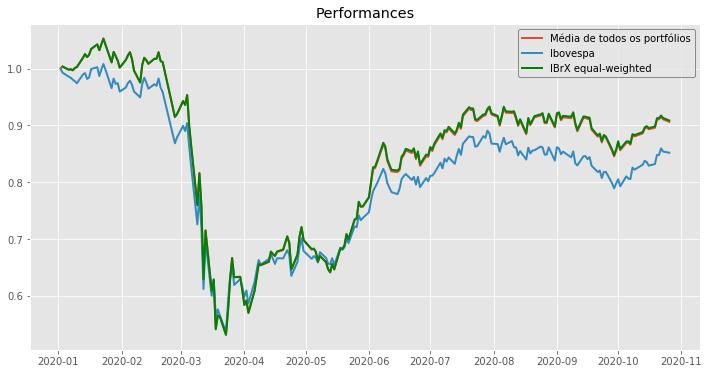

In [23]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot((rand_performance.sum(axis=1)/rand_performance.count(axis=1)), label='Média de todos os portfólios', lw=2)
ax.plot((ibov/ibov.iloc[0]), label='Ibovespa', lw=2)
ax.plot((daily_returns.sum(axis=1)/daily_returns.count(axis=1)).add(1).cumprod(), color='green', label='IBrX equal-weighted', lw=2)
ax.legend(loc='best', edgecolor='black')
ax.set_title('Performances')
#plt.savefig('performances.png')
#ax.set_yscale('log')
plt.show()

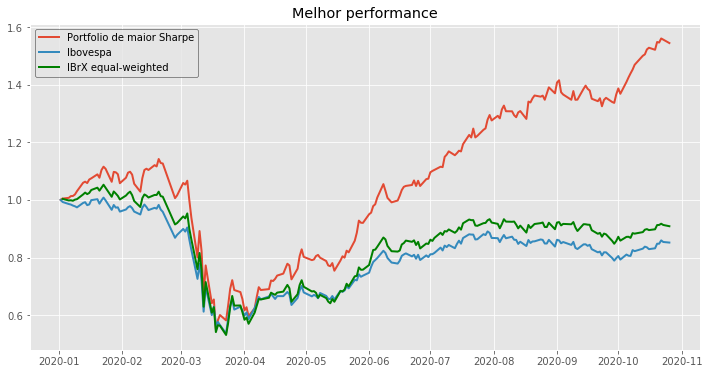

In [24]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(rand_performance[pd.Series(sharpe_dict)[pd.Series(sharpe_dict)>ibov_sharpe].sort_values().tail(1).index[0]], label='Portfolio de maior Sharpe', lw=2)
ax.plot((ibov/ibov.iloc[0]), label='Ibovespa', lw=2)
ax.plot((daily_returns.sum(axis=1)/daily_returns.count(axis=1)).add(1).cumprod(), label='IBrX equal-weighted', lw=2, c='green')
ax.legend(loc='best', edgecolor='black')
ax.set_title('Melhor performance')
#plt.savefig('bestsharpe.png')
#ax.set_yscale('log')
plt.show()

In [25]:
# Composição da carteira de melhor sharpe
random_returns[pd.Series(sharpe_dict)[pd.Series(sharpe_dict)>ibov_sharpe].sort_values().tail(1).index[0]][1]

['VVAR3.SA',
 'ALPA4.SA',
 'MDIA3.SA',
 'MGLU3.SA',
 'BIDI4.SA',
 'GGBR4.SA',
 'CSNA3.SA',
 'DTEX3.SA',
 'WEGE3.SA',
 'NTCO3.SA']

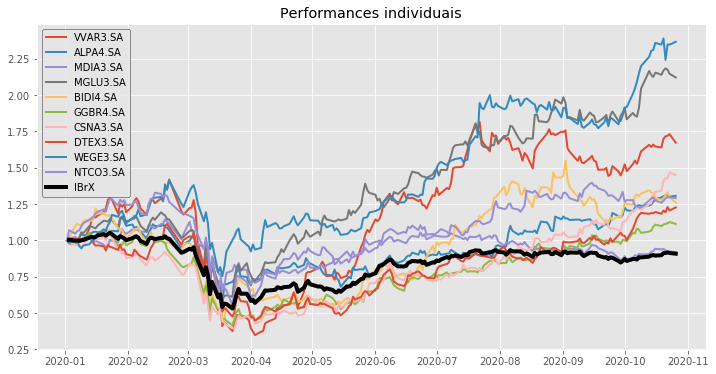

In [28]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot((prices_df[random_returns[pd.Series(sharpe_dict)[pd.Series(sharpe_dict)>ibov_sharpe].sort_values().tail(1).index[0]][1]]/prices_df[random_returns[pd.Series(sharpe_dict)[pd.Series(sharpe_dict)>ibov_sharpe].sort_values().tail(1).index[0]][1]].iloc[0]), lw=2)
ax.plot((daily_returns.sum(axis=1)/daily_returns.count(axis=1)).add(1).cumprod(), label='IBrX equal-weighted', lw=4, c='black')
ax.legend(random_returns[pd.Series(sharpe_dict)[pd.Series(sharpe_dict)>ibov_sharpe].sort_values().tail(1).index[0]][1] + ['IBrX'],loc='best', edgecolor='black')
ax.set_title('Performances individuais')
#plt.savefig('all.png')
plt.show()

In [27]:
# Combinacoes possiveis de portfolios
math.factorial(100)/(math.factorial((100-number))*math.factorial(number))

17310309456440.0